## Import the Libs and Prepare the Data

In [1]:
# Import the required libraries
import glob
import cv2
import numpy as np
import os
from google.colab import drive
from google.colab.patches import cv2_imshow
from skimage.filters import try_all_threshold, threshold_otsu
#from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from skimage.feature import hog
# from cv2.xfeatures2d import SIFT

# Mount the GDrive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
## Prepare the data
## 24 classes corresponding to 24 alphabets in ISL, Same sizes with varying orientation, Almost Balanced
## Dataset available at https://drive.google.com/drive/folders/1al0anvQ2dBp3MGUC1JvMcKAweS26oKkj

## Read the images
image_dir = '/content/drive/MyDrive/Colab_Notebooks/SignLangImages/train/'
image_files = glob.glob(image_dir + '*.jpg')
images = []
labels = []
class_names = []

def showImage(image):
    cv2_imshow(image)
    k = cv2.waitKey(1000)
    cv2.destroyAllWindows()

def convert_to_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def resize_to_128(image):
    return cv2.resize(image, (32, 32), cv2.INTER_LINEAR)

def flatten_image(image):
    return image.flatten()

def normalize(image):
    norm_img = np.zeros((800,800))
    return cv2.normalize(image,  norm_img, 0, 255, cv2.NORM_MINMAX)

def apply_otsu_threshold(image):
  thresh = threshold_otsu(image)
  binary = image > thresh
  return binary.astype('uint8') * 255

def try_all_threshold_(image):
    fig, ax = try_all_threshold(image, figsize=(10, 8), verbose=False)
    return fig,ax

# Feature Preparation
def feature_prep():
  for folder in os.listdir(image_dir):
    folder_path = os.path.join(image_dir, folder)
    if os.path.isdir(folder_path):
        class_name = os.listdir(image_dir).index(folder)  # Use folder name as class label
        print(f"Processing folder: {folder}")
        class_names.append(folder)
        for image_path in glob.glob(os.path.join(folder_path, '*.jpg')):
            #print(f"Processing image: {image_path}")
            img = cv2.imread(image_path)
            image = convert_to_grayscale(img)
            resized_img = resize_to_128(image)
            norm_img = normalize(resized_img)
            # hog_features, keypoints, sift_descriptors = extract_features(norm_img)
            #To DO
            otsu_image = apply_otsu_threshold(norm_img)
            flat_img = flatten_image(norm_img)
            images.append(flat_img)
            labels.append(folder)

            #hog_features.append(hog_features)
            #sift_features.append(sift_descriptors)

#Extract Features using HOG and SIFT
def extract_features(norm_img):
  hog_features, _ = hog(norm_img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2))

  # sift = SIFT_create()
  # keypoints, sift_descriptors = sift.detectAndCompute(norm_img)

  # return hog_features, keypoints, sift_descriptors

In [3]:
# Prepare the data
feature_prep()
categories = labels
images = np.array(images)
labels = np.array(labels)
print(labels)

print(type(images))
print(type(labels))

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
encoded_labels = le.fit_transform(labels)
print(encoded_labels)
#labels = to_categorical(labels)
print(images.shape)
print(labels.shape)
#cv2_imshow(images[0])

Processing folder: W
Processing folder: K
Processing folder: V
Processing folder: Y
Processing folder: B
Processing folder: E
Processing folder: P
Processing folder: Q
Processing folder: L
Processing folder: X
Processing folder: M
Processing folder: F
Processing folder: S
Processing folder: T
Processing folder: D
Processing folder: C
Processing folder: H
Processing folder: A
Processing folder: O
Processing folder: G
Processing folder: U
Processing folder: I
Processing folder: R
Processing folder: N
['W' 'W' 'W' ... 'N' 'N' 'N']
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
[21 21 21 ... 12 12 12]
(4972, 1024)
(4972,)


In [ ]:
# Morphological Gradient - Optional
# https://docs.opencv.org/4.x/d9/d61/tutorial_py_morphological_ops.html
# import numpy as np
# kernel = np.ones((5,5),np.uint8)
# gradient = cv2.morphologyEx(resized_up, cv2.MORPH_GRADIENT, kernel)

## Utility to Load the saved model

In [19]:
import pickle
with open('/content/drive/MyDrive/model_hyper.pkl', 'rb') as f:
  model = pickle.load(f)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

## Classification with Support Vector Machine (SVM)

In [ ]:
# Classification with SVM with varied kernels, Gamma
# 10 Fold Cross Validation
# GridSearch has builtin cv param
from sklearn import svm
from sklearn.model_selection import train_test_split

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

with tf.device('/device:GPU:0'):
  #Create the model
  model=svm.SVC(probability=True)
  model.fit(X_train,y_train)


In [ ]:
from sklearn.metrics import accuracy_score
with tf.device('/device:GPU:0'):
  !nvidia-smi
  y_pred=model.predict(X_test)
  accuracy = accuracy_score(y_test, y_pred)
  print(f"Accuracy: {accuracy:.2f}")

/bin/bash: line 1: nvidia-smi: command not found
Accuracy: 0.99


In [ ]:
from sklearn.model_selection import GridSearchCV
# Hyper Param Tuning
param_grid={'C':[0.1,1,10],'gamma':[0.001,0.1,1],'kernel':['linear','rbf']}

with tf.device('/device:GPU:0'):
  !nvidia-smi
  grid_search=GridSearchCV(model,param_grid, cv=10)
  grid_search.fit(X_train,y_train)
  grid_search.best_params_


/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
#### Get the best hyperparameters - runtime around 2 hours with 32x32 - 4972 images
from sklearn.metrics import accuracy_score
best_C = grid_search.best_params_['C']
best_gamma = grid_search.best_params_['gamma']
best_kernel = grid_search.best_params_['kernel']

print(best_C) # got 0.1
print(best_gamma) # got 0.001
print(best_kernel) # got linear

with tf.device('/device:GPU:0'):
  print(tf.config.list_physical_devices('GPU'))
  # Train SVM with the best C value
  svm_best = svm.SVC(C=best_C, gamma=best_gamma, kernel=best_kernel)
  svm_best.fit(X_train, y_train)

  # Make predictions on test data
  y_pred = svm_best.predict(X_test)

  # Evaluate accuracy
  accuracy = accuracy_score(y_test, y_pred)
  print(f"Accuracy: {accuracy:.2f}")

0.1
0.001
linear
[]
Accuracy: 0.99


## Classification with KNN

In [17]:
######### Nearest Neighbour
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Create a KNN classifier
neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(X_train, y_train)

# Make predictions on the test set
y_pred = neigh.predict(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
#print(neigh.predict_proba(X_test))


Accuracy: 0.9919597989949749


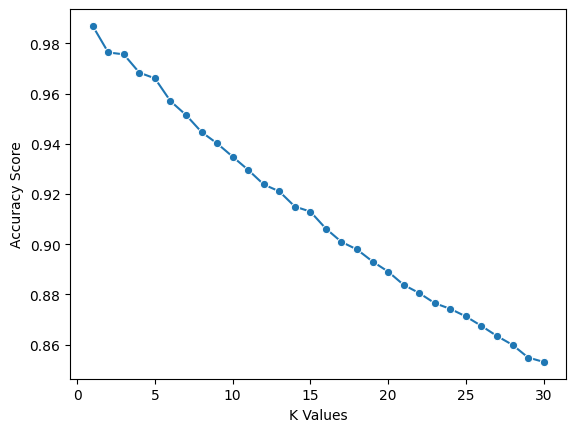

In [8]:
# Try to find out the best value of K
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

k_values = [i for i in range (1,31)]
scores = []

scaler = StandardScaler()
X = scaler.fit_transform(X_train)

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, X, y_train, cv=5)
    scores.append(np.mean(score))

sns.lineplot(x = k_values, y = scores, marker = 'o')
plt.xlabel("K Values")
plt.ylabel("Accuracy Score")
plt.show()

In [ ]:
y_pred=model.predict(X_test)
print("The predicted Data is :")
#print(y_pred)
print("The actual data is:")
#print(np.array(y_test))
print(f"The model is {accuracy_score(y_pred,y_test)*100}% accurate")

The predicted Data is :
The actual data is:
The model is 99.49748743718592% accurate


In [ ]:
##

## Testing with real-time images

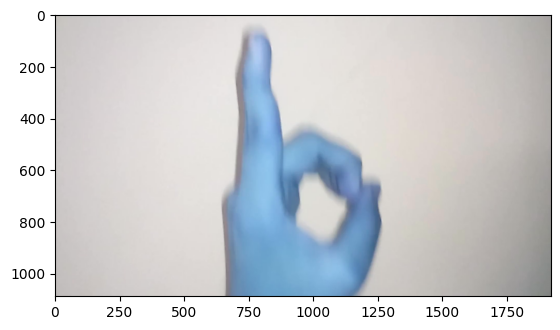

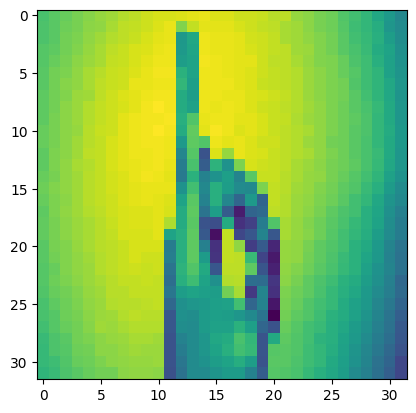

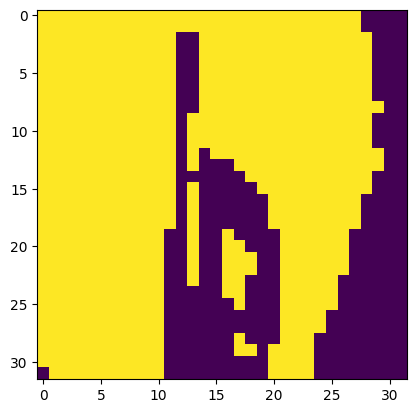

Predicted class: ['D']
A = 0.00%
B = 0.00%
C = 0.00%
D = 100.00%
E = 0.00%
F = 0.00%
G = 0.00%
H = 0.00%
I = 0.00%
K = 0.00%
L = 0.00%
M = 0.00%
N = 0.00%
O = 0.00%
P = 0.00%
Q = 0.00%
R = 0.00%
S = 0.00%
T = 0.00%
U = 0.00%
V = 0.00%
W = 0.00%
X = 0.00%
Y = 0.00%


In [34]:
import matplotlib.pyplot as plt
from skimage.transform import resize
#url=input(r'Enter URL of Image :')
model = neigh
img=cv2.imread("/content/drive/MyDrive/Colab_Notebooks/SignLangImages/test/002.jpg")
if img is None:
    print("Failed to load image. Please check the URL and try again.")
else:
    plt.imshow(img)
    plt.show()
    image = convert_to_grayscale(img)
    resized_img = resize_to_128(image)
    norm_img = normalize(resized_img)
    otsu_image = apply_otsu_threshold(norm_img)
    flat_img = flatten_image(norm_img)
    test_image = np.array([flat_img])
    plt.imshow(norm_img)
    plt.show()
    plt.imshow(otsu_image)
    plt.show()

    # Model Predict
    predicted_labels = model.predict(test_image)
    decoded_labels = le.inverse_transform(encoded_labels)

    print("Predicted class:", predicted_labels)

    # Model Probability Predict
    probabilities = model.predict_proba(test_image)
    predicted_indices = np.argmax(probabilities, axis=1)  # Find index of class with highest probability
    pred_decoded_labels = le.inverse_transform(predicted_indices)  # Decode to original labels


    # Check if probabilities have the expected shape (e.g., number of classes)
    if len(probabilities.shape) == 2 and probabilities.shape[1] == len(model.classes_):
      # Safe to iterate over probabilities and class names
      for i, class_name in enumerate(model.classes_):
        probability = probabilities[0][i] * 100  # Assuming probabilities are not already in percentages
        print(f"{class_name} = {probability:.2f}%")  # Format probability with two decimal places
    else:
      print("Warning: Probability shape mismatch. Check model output or data preprocessing.")



## Utility to dump/save the model

In [ ]:
import pickle as pk
from google.colab import files
with open('model_hyper.pkl','wb') as f:
    pk.dump(model,f)
#files.download('/content/model_hyper.pkl')
!cp model_hyper.pkl /content/drive/MyDrive/  # Replace with your desired Drive location

In [ ]:
# End of part 1
# More robust feature vectors: HOG, SIFT, SURF
# Bag of visual words

feature_prep()
hog, = extract_features(norm_img)

## Deep Learning